### Imports


In [282]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time

plt.style.use("default")

### Runtime


In [283]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper


### Read data


In [284]:
#name_of_dataset = 'Angle'
name_of_dataset = 'Sshape'

dataset = loadmat("Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0, 0][0].shape[0]
dim_of_function = size_of_state


In [285]:
num_of_train_datasets = 4
x_cell = None 
y_cell = None
init_position_of_demos = np.zeros((size_of_state, num_of_train_datasets))
# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]
    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file
    init_position_of_demos[:,i] = position_dataseries[:,0]
    # create x_cell if not existing
    if x_cell is None : 
        x_cell = position_dataseries
    else : 
        # Example: two arrays of (2,1000) (2,1000) -> get 1 array with (2,2000)
        x_cell = np.concatenate((x_cell, position_dataseries), axis = 1)
    if y_cell is None : 
        y_cell = velocity_dataseries
    else : 
        y_cell = np.concatenate((y_cell, velocity_dataseries), axis = 1)

x_train = x_cell
y_train = y_cell

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1]

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
init_condition = init_position_of_demos.mean(axis = 1) # computes the mean across each columns

#### Plot dataset the four training data sets

C:\Users\vilde\AppData\Local\Temp\ipykernel_20832\1128368145.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


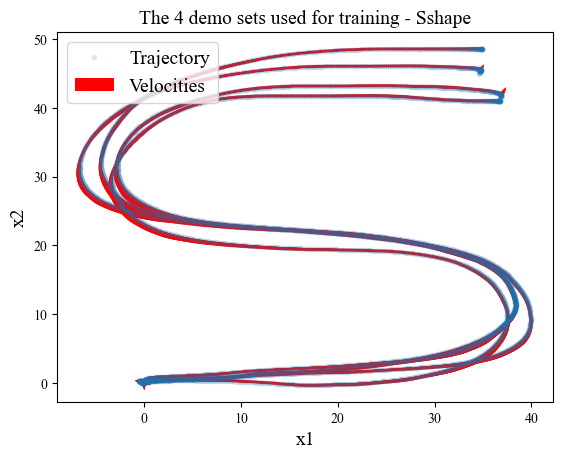

In [286]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('The 4 demo sets used for training - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0, :], x_train[1, :], '.', alpha=0.12)
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :], color='red', scale=700)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Velocities'], loc="upper left", frameon=True, prop={'size': 14})
fig_dataset.show()
#plt.savefig(r"lasa_figures/"+name_of_dataset+"_lasa_trajectory_4training_demos.eps", format="eps")
axes = plt.gca()  # gca = get current axes, from my last plot


#### Define vector-field and axis


In [287]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0


### Vector-valued RFF for Gaussian Separable Kernel


In [288]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)


def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector)


def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))


def phi(x, w, b, N, d, dim):
    phi = np.zeros((dim*N, dim*d))
    for i in range(0, N):
        psi = capital_psi(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi


#### Psi derivative


In [289]:
def psi_derivative(x, w, b):
    return np.sqrt(2) * (-np.sin(w.T@x + b)) * w

#### Finding alpha without constraint


In [290]:
@runtime
def alpha_approx(x, y, w, b, dim, d, lam, N):
    phi_ = phi(x, w, b, N, d, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim', dim)
    d_param = pc.Constant('d', d)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (d_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param *
                                                             alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var


#### Alpha with contraction constraint


In [291]:
@runtime
def alpha_approx_with_constraint(x, y, w, b, dim, d, lam, N, mu, constraint_points):
    phi_ = phi(x, w, b, N, d, dim)
    mu = mu * np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim', dim)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant(
        'constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        for j in range(d):
            index = 2*j
            psi_derivative_param = pc.Constant(
                'psi_derivative', psi_derivative(x_i, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param *
                                                             alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var


#### Variables


In [292]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100 

if name_of_dataset == 'Sshape':
    num_of_samples = 200

#w = randn(size_of_state, num_of_samples)/sigma
#b = rand(1, num_of_samples)*2*np.pi

w = np.load('RFF_parameters/w_'+name_of_dataset+'_no_mean.npy') 
b = np.load('RFF_parameters/b_'+name_of_dataset+'_no_mean.npy')

mu = 0.0

#### Random Fourier Features & Regression


In [293]:
alpha_rff = alpha_approx(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points)


 Function alpha_approx took 32.6009 seconds


In [294]:
#alpha_rff_with_constraint = alpha_approx_with_constraint(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points)

##### Create callable function for learnt dynamics

In [295]:
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff
    return func

""" def learnt_model_with_constraint(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff_with_constraint
    return func """

' def learnt_model_with_constraint(t, x):\n    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff_with_constraint\n    return func '

#### Solve differential equation using learnt model with solver_ivp


In [296]:
timespan = np.array([time_series[0],time_series[-1]])
t_series = np.linspace(time_series[0],time_series[-1], 1000)
#data_series = solve_ivp(learnt_model_with_constraint, timespan, init_condition, t_eval=t_series).y
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t_series).y

#### Plot simulated trajectory and streamslices for learnt model


In [297]:
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    # get velocities at each point with the learnt model
    #Y_prime = learnt_model_with_constraint(t, np.array([value, X2[i, j]]))
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i, j] = Y_prime[0]
    v_learnt[i, j] = Y_prime[1]

#### Combined solution and vector field for learnt model


C:\Users\vilde\AppData\Local\Temp\ipykernel_20832\2147209311.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


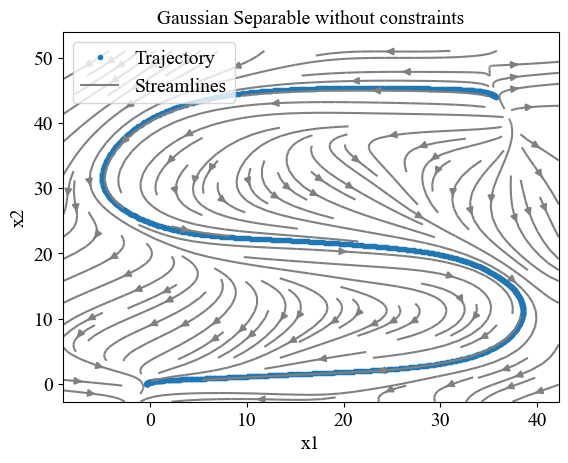

In [298]:
fig_learntmodel = plt.figure(1)
plt.title('Gaussian Separable without constraints', fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density=1.1, color='gray')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc="upper left", frameon=True, prop={'size': 14})
fig_learntmodel.show()
#plt.savefig(r"lasa_figures/"+name_of_dataset+"_lasa_gauss_rff_without_constraints_no_mean.eps", format="eps", transparent=True)

#### Reproducing accuracy


[0.72944678 0.         0.        ]


C:\Users\vilde\AppData\Local\Temp\ipykernel_20832\2552986056.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


[0.72944678 1.47704622 0.        ]
[ 0.72944678  1.47704622 19.59995572]
7.268816237836142


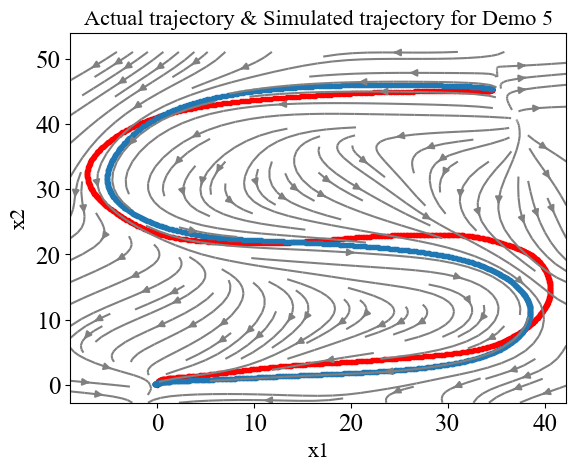

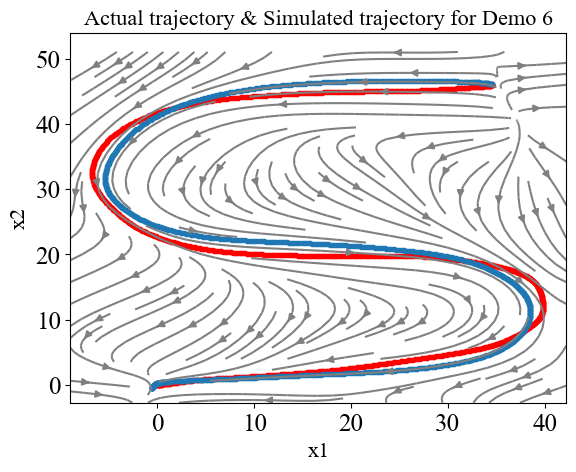

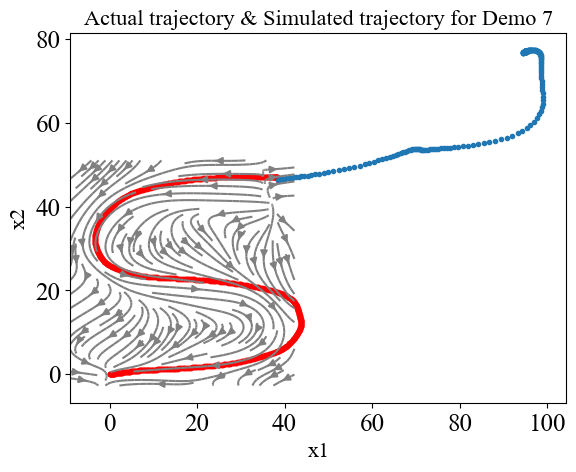

In [299]:
num_of_test_datasets = num_of_demos - num_of_train_datasets
trajectory_error = np.zeros(num_of_test_datasets)

for i in range(num_of_test_datasets):
    demo_pos = num_of_train_datasets + i
    actual_trajectory = dataset['demos'][0, demo_pos][0, 0][0]
    actual_time = dataset['demos'][0, demo_pos][0, 0][1]
    timespan = np.array([actual_time[:, 0], actual_time[:, -1]])
    initial_condition = actual_trajectory[:, 0]
    simulated_trajectory = solve_ivp(learnt_model, timespan, initial_condition, t_eval=actual_time[0]).y
    error = np.mean(np.linalg.norm(actual_trajectory - simulated_trajectory, ord=2, axis=0) / actual_time[:, -1])
    trajectory_error[i] = error
    print(trajectory_error)
    demo_number = demo_pos+1
    fig_learntmodel = plt.figure(i+num_of_train_datasets)
    plt.title('Actual trajectory & Simulated trajectory for Demo ' + str(demo_number), fontsize=16)
    plt.plot(actual_trajectory[0, :], actual_trajectory[1, :], '.', linewidth=0.1, color='r')
    plt.plot(simulated_trajectory[0, :], simulated_trajectory[1, :], '.', linewidth=0.1)
    plt.streamplot(X1, X2, u_learnt, v_learnt, density=1.1, color='gray')
    plt.xlabel('x1', fontsize=16)
    plt.ylabel('x2', fontsize=16)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    fig_learntmodel.show()
    #plt.savefig(r"lasa_figures/"+name_of_dataset+"_lasa_gauss_without_constraints_accuracy_demo" +str(demo_number)+"_no_mean.eps", format="eps", transparent=True)

trajectory_mean_error = np.mean(trajectory_error)
print(np.mean(trajectory_error))

In [300]:
#np.save('RFF_parameters/w_'+name_of_dataset+'_no_mean', w)
#np.save('RFF_parameters/b_'+name_of_dataset+'_no_mean', b)